In [1]:
# libraries
import os
from pathlib import Path

import numpy as np
import random
from math import *
import scipy
#from sympy import *
from scipy.stats import binom
from scipy.stats.distributions import chi2
import matplotlib.pyplot as plt
import pandas as pd

from sympy import Eq, Symbol as sym, solve
import sys

# presentation in the dataframe
#pd.options.display.float_format = '{:.4f}'.format
#pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4e}'.format)
# activating latex printing in matplotlib
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Preliminaries - Ternary setup

### Coordinates

In [2]:
h = sqrt(3)/2 # = the hight of an equilateral triangle, where each side = 1


# Per given coordinate y in [0,1] of Ti, the appropriate 
#   isoclines in the ternary trianlgle are folrmulated

def T1(y,x): # -
    return y*h

def T2(y,x): # \
    a = 2*h
    b = sqrt(3)*(0.5-y) 
    return -a*x + b

def T3(y,x): # /
    a = 2*h
    b = sqrt(3)*(0.5-y) 
    return a*x + b


# given a cartizian coordinate in R^2, transform to ternary coordinates
# 1st coordinate is T_1 == -
# 2nd coordinate is T_2 == \
# 3rd coordinate is T_3 == /

def ternary_coord(a,b): # converting cartisian -> ternary coordinates
    t1=b/h
    
    y = sym('y')
    eqa_2 = Eq(T2(y,a), b)
    t2 = solve(eqa_2,y)[0]
    
    z = sym('z')
    eqa_3 = Eq(T3(z,a), b)
    t3 = solve(eqa_3,z)[0]
    
    return (t1,t2,t3)


def cartizian(x,y,z): # converting ternary -> cartisian coordinates
    return ((z-y)/2, x*h)

In [3]:
# verification- it works :)

x=random.random()
y=random.random()

print(cartizian(ternary_coord(x,y)[0],ternary_coord(x,y)[1],ternary_coord(x,y)[2])[0]-x)
print(cartizian(ternary_coord(x,y)[0],ternary_coord(x,y)[1],ternary_coord(x,y)[2])[1]-y)

-1.33226762955019e-15
0.0


## Plotting- help functions

In [4]:
# help functions to plotting

# returning the linits x points for the correct sketching of Ti(y,.) in our triangle


def T1_lim(y): # - given y coordinate of T1, returns the delimeters [x_l,x_r] to plot it in 
    
    # The general logic: y =T3(0,x_left)= T2(1, x_right)
    
    y=y*h # the real height of coordinate y in T1 (as it is all scaled by h)
    x_l = sym('x_l') # x_left
    eqa_l = Eq(T3(0,x_l),y)
    x_L = float(solve(eqa_l,x_l)[0])

    x_r = sym('x_r') # x_right
    eqa_r = Eq(T2(0,x_r),y)
    x_R = float(solve(eqa_r,x_r)[0])
    return (x_L,x_R) 



#full plot
def T2_lim(y): # | given y coordinate of T2, returns the delimeters [x_l,x_r] to plot it in 
    
    # The general logic:  T3(0,x_left)= T2(y, x_left),  0= T2(y, x_right) should be =1-y-0.5=0.5-y
    
    x_l = sym('x_l') # x_left
    eqa_l = Eq(T3(0,x_l),T2(y, x_l))
    x_L = float(solve(eqa_l,x_l)[0])

    x_r = sym('x_r') # x_right
    eqa_r = Eq(T2(y,x_r),0)
    x_R = float(solve(eqa_r,x_r)[0])
    return (x_L,x_R) 

    
#full plot
def T3_lim(y): # / given y coordinate of T3, returns the delimeters [x_l,x_r] to plot it in 
    
    # The general logic:   0= T3(y, x_left) should be = y-0.5 ,  T3(y,x_right)= T2(0, x_right)  
   
    x_l = sym('x_l') # x_left
    eqa_l = Eq(T3(y,x_l),0)
    x_L = float(solve(eqa_l,x_l)[0])

    x_r = sym('x_r') # x_right
    eqa_r = Eq(T3(y,x_r),T2(0, x_r) )
    x_R = float(solve(eqa_r,x_r)[0])
    return (x_L,x_R)

# plotting only the right half
def T3_lim_symm(y): # | given y coordinate of T2, returns the delimeters [x_l,x_r] to plot it in, for the 
    
    # The general logic:  T3(0,x_left)= T2(y, x_left),  0= T2(y, x_right) should be =1-y-0.5=0.5-y
   
    x_l = sym('x_l') # x_left
    eqa_l = Eq(T3(y,x_l),0)
    x_L = float(solve(eqa_l,x_l)[0])

    x_r = sym('x_r') # x_right
    eqa_r = Eq(T3(y,x_r),T2(0, x_r) )
    x_R = float(solve(eqa_r,x_r)[0])
    
    
    return (max(x_L,0),x_R) 

In [5]:
def return_triangle_coord(a1,b1,a2,b2,a3,b3): # input coordiante of subtriangle, return two arrays in cartisian 
    # coordinates, and direction of triangle "up"/"down" as string.
    x_s = sym('x_s') # s- spitz node
    x_l = sym('x_l') # l- left node
    x_r = sym('x_r') # r- right node

    eqa_r = Eq(T2(a2, x_r) ,T3(b3,x_r)) # true for both up & down triangles
    x_r = float(solve(eqa_r,x_r)[0])

    eqa_l = Eq(T2(b2, x_l) ,T3(a3,x_l))   # true for both up & down triangles
    x_l = float(solve(eqa_l,x_l)[0])
    
  # write a condition to detect direction
  # a triangle is an up-triangle if and only if the y component e.g. T2(b2, x_l)
    # of any of the base nodes is intersecting b1/h (the "higher" T1 coordinate)
    if abs(T2(b2,x_l)-a1*h) <= 10**-14: # T2(b2,x_l) == (a1*h)  
        direction = "up"  # think later if we want to store this as strings really, maybe not for some condition later-on
        
        eqa_s = Eq(T2(a2, x_s) ,T3(a3,x_s))
        x_s = float(solve(eqa_s,x_s)[0])

        triangley = [ a1*h, b1*h, a1*h, a1*h ]  # y coordinates of [ x_l,x_s ,x_r , x_l ] 
    
    
    if  abs(T2(b2,x_l)-b1*h) <= 10**-14 :# T2(b2,x_l) == (b1*h)  :
        direction = "down"
    
        eqa_s = Eq(T2(b2, x_s) ,T3(b3,x_s))
        x_s = float(solve(eqa_s,x_s)[0])
    
        triangley = [ b1*h, a1*h, b1*h, b1*h ]   # y coordinates of [ x_l,x_s ,x_r , x_l ] 

    
    trianglex = [ x_l, x_s ,x_r , x_l ] 
    return (trianglex, triangley, direction) # ready to be printed with: plt.fill(trianglex, triangley)

In [6]:
# reflected coordinate of the reflected triangle
def ref(a1,b1,a2,b2,a3,b3):
    return (a1,b1,a3,b3,a2,b2)

In [7]:
# lets make a data structure that has the coordinate of a right triangle, the cartesian location of its node and mid-point
# for the plotting of the p-value results in the sub-triangles

def mid_point_triangle(a1,b1,a2,b2,a3,b3): # in cartesian coordinates
    trianglex, triangley, direction=return_triangle_coord(a1,b1,a2,b2,a3,b3)
    mid_x= trianglex[1]# x coordinate of the top
    
    if direction == "up":          
            mid_y= triangley[0] +(trianglex[1]-trianglex[0])/2 # simple geometry
    else: #    direction == "down"     
        mid_y= triangley[0] +2*(trianglex[0]-trianglex[1])/3 # simple geometry
        
    return (mid_x,round(mid_y, 4))    

### Plotting the Data

In [8]:
def plot(data, alpha): # rudimental plotting
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes()

    x_side_T2 = np.linspace(0, 0.5, 100)
    x_side_T3 = np.linspace(-0.5, 0, 100)

    ax.plot(x_side_T2, T2(0,x_side_T2),"k",linewidth=2);
    ax.plot(x_side_T3, T3(0,x_side_T3),"k",linewidth=2);
    plt.hlines(y = 0, xmin =-0.5, xmax = 0.5,color="k",linewidth=2)
    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])


    # coordinates!
    for i in range(1, int(1/alpha)):
        y=i*alpha
        # ploting T1 coordinates
        plt.hlines(y = y*h, xmin = T1_lim(y)[0], xmax = T1_lim(y)[1],color="crimson",linewidth=1)

        # ploting T2 coordinates
        x2 = np.linspace(T2_lim(y)[0], T2_lim(y)[1], 100)
        ax.plot(x2, T2(y,x2), "dodgerblue", linewidth=1)

        # ploting T3 coordinates
        x3 = np.linspace(T3_lim(y)[0], T3_lim(y)[1], 100)
        ax.plot(x3, T3(y,x3), "gold", linewidth=1)

    # single vline with full ymin and ymax
    plt.vlines(x=0, ymin=0, ymax=h, colors="grey", ls=':')

    x_data = cartizian(data["Tb"],data["Tc"],data["Tr"])[0] # x coordinates of the data points to be plotted
    y_data = cartizian(data["Tb"],data["Tc"],data["Tr"])[1] # y coordinates of the data points to be plotted
    
    plt.scatter(x_data,y_data, color = "lightsteelblue",alpha=0.4,s=9)
    
    plt.text(-0.02, 0.88, 'T1', size=12, color="crimson")
    plt.text(0.54, -0.01, 'T3', size=12, color= "darkgoldenrod")
    plt.text(-0.58, -0.01, 'T2', size=12, color = "dodgerblue")
    
    
    # printing the coordinates
    
    coord= np.arange(0,1+alpha,alpha)
    T_1 = np.arange(0,0.5+alpha/2,alpha/2)
    T_2 = np.arange(-0.5,0+alpha/2,alpha/2)
    T_3 = np.arange(-0.5,0.5+alpha,alpha)
        
    # coordintes T1
    for i in range(len(T_1)):
        label= str(round(1-coord[i],2))
        x=T_1[i]
        y=T2(0,x)
        plt.text(x+0.01, y, label , size=7, color = "crimson")
    
    # coordintes T2
    for i in range(len(T_2)):
        label= str(round(1-coord[i],2))
        x=T_2[i]
        y=T3(0,x)
        plt.text(x-0.04, y, label , size=7, color = "dodgerblue")  
    
    # coordintes T3    
    for i in range(len(coord)):
        label= str(round(coord[i],2))
        x=T_3[i]
        plt.text(x, -0.03, label , size=7, color = "darkgoldenrod")   
        
      # removing the box lines around the plot
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['top'].set_color('none')
     
    title = "data_granuality_" + str(alpha)  +".png"  
    plt.savefig(title)
    return fig


### Plotting Results

In [9]:
# plotting the analysis, input is res= results dataframe, which is the output of triangles_analysis
# (data, granularity). Also the granuality needs to be inserted as a string.
# In case a non-orthodox choice was used, then the different granuality need to be specified as a float

def plot_results(res, granuality):

    # in case the user did not specify a granuality level- means he used one of the default
    alpha = granuality 
    if granuality == "super fine":
        alpha = 0.05 # granulity "super fine" was used
    if granuality == "fine":
        alpha = 0.1 # granulity "fine" was used
    if granuality == "coarse":
        alpha = 0.25 # granulity "coarse" was used
  

    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes()

    x_side_T2 = np.linspace(0, 0.5, 100)
    #x_side_T3 = np.linspace(-0.5, 0, 100)

    ax.plot(x_side_T2, T2(0,x_side_T2),"k",linewidth=2);

    plt.hlines(y = 0, xmin =0, xmax = 0.5,color="k",linewidth=2)
    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])


    # coordinates!
    #for i in range(1, int(1/alpha)):

    # ploting T2 coordinates
    for i in range(1,int(1/(2*alpha))):

        y=i*alpha

        x2 = np.linspace(0, T2_lim(y)[1], 100)
        ax.plot(x2, T2(y,x2), "dodgerblue", linewidth=1)

    # ploting T1 & T3 coordinates
    for i in range(1, int(1/alpha)):

        y=i*alpha

        # ploting T1 coordinates
        plt.hlines(y = y*h, xmin = 0, xmax = T1_lim(y)[1],color="crimson",linewidth=1)


        # ploting T3 coordinates
        x3 = np.linspace(T3_lim_symm(y)[0], T3_lim_symm(y)[1], 100)
        ax.plot(x3, T3(y,x3),"gold", linewidth=1)

    # single vline with full ymin and ymax
    plt.vlines(x=0, ymin=0, ymax=h, colors="grey", ls=':')

    p_plt=[] # a list of the mid -points of the subtraingles, to plot the p-values via scatter function

    for i in range(res["D-LR"].size): # going through all right sub-triangles
        a1=res["coord. (T1, T2, T3)"][i][0][0]
        b1=res["coord. (T1, T2, T3)"][i][0][1]

        a2=res["coord. (T1, T2, T3)"][i][1][0]
        b2=res["coord. (T1, T2, T3)"][i][1][1]

        a3=res["coord. (T1, T2, T3)"][i][2][0]
        b3=res["coord. (T1, T2, T3)"][i][2][1]

        # sketching the subtriangle
        trianglex, triangley, direction=return_triangle_coord(a1,b1,a2,b2,a3,b3)
        d_lr_color_score = (res["D-LR"][i] + 1 )/2 # normalzing to get a score between [0,1]
        # , color according to the d_lr result
        plt.fill(trianglex, triangley,color=(d_lr_color_score, 1-d_lr_color_score, 1-d_lr_color_score))

        # sketching points that indicate significant p-values in the relevent subtriangles
        x,y = mid_point_triangle(a1,b1,a2,b2,a3,b3)
        p=res["p-value(g-test)"][i]
        if p < 0.05 and p >= 0.001 :
            ax.scatter(x,y,color='yellow', marker="*", alpha = 0.4, s =9)
        if p < 0.001 and p>= 10**(-5):
            ax.scatter(x,y,color="darkslateblue", marker="*", alpha =0.9, s =22)
        if p<= 10**(-5):
            ax.scatter(x,y,color="black", marker="*", alpha = 1, s =25)



    # # the p-values starts
    # p_plot = pd.DataFrame(p_plt)
    # p_plot.columns=["x","y","p"]
    # ax.scatter(p_plot["x"], p_plot["y"],color="midnightblue", marker="*", alpha = 1-p_plot["p"], s =24*(1-p_plot["p"]))

    # creating the legends
    # colors of the sub-triangles
    d_lr_color_score = 0
    pp1 = plt.Rectangle((0.2, 0.85), 0.05, 0.05, color=(d_lr_color_score, 1-d_lr_color_score, 1-d_lr_color_score)) # d_lr_color_score = 0
    d_lr_color_score = 0.5
    pp2 = plt.Rectangle((0.25, 0.85), 0.05, 0.05, color=(d_lr_color_score, 1-d_lr_color_score, 1-d_lr_color_score)) # d_lr_color_score = 0.5
    d_lr_color_score = 1
    pp3 = plt.Rectangle((0.3, 0.85), 0.05, 0.05, color=(d_lr_color_score, 1-d_lr_color_score, 1-d_lr_color_score))# d_lr_color_score = 1
    ax.add_patch(pp1)
    ax.add_patch(pp2)
    ax.add_patch(pp3)
    plt.text(0.17, 0.865, "$D_{lr} =           -1$", size=8)
    plt.text(0.256, 0.865, '     0', size=8)
    plt.text(0.31, 0.865, '1', size=8)
    # the p-values legend
    #p <= 10**-5
    ax.scatter(0.2, 0.8,color="black", marker="*", alpha = 1, s =25)
    plt.text(0.214, 0.8, "$p < 10^{-5}$", size=8)
    # p <= 0.001
    ax.scatter(0.2, 0.77,color="darkslateblue", marker="*", alpha =0.9, s =22)
    plt.text(0.214, 0.77, "$p < 0.001$", size=8)
    # p_ex <= 0.05
    ax.scatter(0.2, 0.74,color="darkgoldenrod", marker="*", alpha = 0.4, s =9)
    plt.text(0.214, 0.74, "$p < 0.05$", size=8)


    # dubbing the nodes
    plt.text(-0.02, 0.88, 'T1', size=12, color="crimson")
    plt.text(-0.03, -0.01, 'T2', size=12, color = "dodgerblue")
    plt.text(0.54, -0.01, 'T3', size=12, color= "darkgoldenrod")


    # printing the coordinates

    coord= np.arange(0,1+alpha,alpha)
    T_1 = np.arange(0,0.5+alpha/2,alpha/2)
    T_2_3 = np.arange(0,0.5+alpha,alpha)

    # coordintes T1
    for i in range(len(T_1)):
        label= str(round(1-coord[i],2))
        x=T_1[i]
        y=T2(0,x)
        plt.text(x+0.01, y, label , size=7, color = "firebrick")

    # coordintes T2
    for i in range(len(T_2_3)-2):
        label= str(round(coord[i]+alpha,2))
        x=0
        y=T2(coord[i]+alpha,0)
        plt.text(x-0.02, y, label , size=7, color = "dodgerblue")  

    # coordintes T3    
    for i in range(len(T_2_3)):
        label= str(round(coord[i]+0.5,2))
        x=T_2_3[i]
        plt.text(x, -0.03, label , size=7, color = "darkgoldenrod")   

    # removing the box lines around the plot
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['top'].set_color('none')


    title = "analysis_granuality_" + str(alpha)  +".png"  
    plt.savefig(title)
    return fig

In [10]:
# plotting the basic two main subtriangles- symmetry analysis basic check,
#saves the analysis plot and returns (d_lr, g_test,_p_value) of the comparison
def plot_fundemental_asymmetry(data):
    fig = plt.figure(figsize=(6, 4))
    ax = plt.axes()

    x_side_T2 = np.linspace(0, 0.5, 100)
    x_side_T3 = np.linspace(-0.5, 0, 100)

    ax.plot(x_side_T2, T2(0,x_side_T2),"k",linewidth=2);
    ax.plot(x_side_T3, T3(0,x_side_T3),"k",linewidth=2);
    plt.hlines(y = 0, xmin =-0.5, xmax = 0.5,color="k",linewidth=2)
    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])


    # single vline with full ymin and ymax
    plt.vlines(x=0, ymin=0, ymax=h, colors="black")


    # sketching the subtriangles
    # coordinates of right-main subtriangle
    trianglex_R=[0,0,0.5,0] 
    triangley_R = [0,h,0,0]

    # coordinates of right-main subtriangle
    trianglex_L=[-0.5,0,0,-0.5] 
    triangley_L = [0,h,0,0]

    main_n_r, main_n_l, main_d_lr,main_g_test, main_p_value = fundemental_asymmetry(data)

    main_d_lr_left = (main_n_l-0.5*(main_n_l+main_n_r) )/(0.5*(main_n_l+main_n_r)) # for the plotting

    d_lr_color_score_R = (main_d_lr + 1 )/2 # normalzing to get a score between [0,1]
    d_lr_color_score_L = (main_d_lr_left + 1 )/2 # normalzing to get a score between [0,1]

    # FILLING THE SUBTRINAGLES color according to the d_lr result
    plt.fill(trianglex_R, triangley_R,color=(d_lr_color_score_R, 1-d_lr_color_score_R, 1-d_lr_color_score_R))
    plt.fill(trianglex_L, triangley_L,color=(d_lr_color_score_L, 1-d_lr_color_score_L, 1-d_lr_color_score_L))

    # sketching points that indicate significant p-values in the right subtraingle
    x= 0.15
    y= 0.4*h
    p=main_p_value
    if p < 0.05 and p >= 0.001 :
        ax.scatter(x,y,color='yellow', marker="*", alpha = 0.4, s =9)
    if p < 0.001 and p>= 10**(-5):
        ax.scatter(x,y,color="darkslateblue", marker="*", alpha =0.9, s =22)
    if p<= 10**(-5):
        ax.scatter(x,y,color="black", marker="*", alpha = 1, s =25)



    # # the p-values starts
    # p_plot = pd.DataFrame(p_plt)
    # p_plot.columns=["x","y","p"]
    # ax.scatter(p_plot["x"], p_plot["y"],color="midnightblue", marker="*", alpha = 1-p_plot["p"], s =24*(1-p_plot["p"]))

    # creating the legends
    # colors of the sub-triangles
    d_lr_color_score = 0
    pp1 = plt.Rectangle((0.2, 0.85), 0.05, 0.05, color=(d_lr_color_score, 1-d_lr_color_score, 1-d_lr_color_score)) # d_lr_color_score = 0
    d_lr_color_score = 0.5
    pp2 = plt.Rectangle((0.25, 0.85), 0.05, 0.05, color=(d_lr_color_score, 1-d_lr_color_score, 1-d_lr_color_score)) # d_lr_color_score = 0.5
    d_lr_color_score = 1
    pp3 = plt.Rectangle((0.3, 0.85), 0.05, 0.05, color=(d_lr_color_score, 1-d_lr_color_score, 1-d_lr_color_score))# d_lr_color_score = 1
    ax.add_patch(pp1)
    ax.add_patch(pp2)
    ax.add_patch(pp3)
    plt.text(0.1, 0.865, "$D_{lr} =           -1$", size=8)
    plt.text(0.256, 0.865, '     0', size=8)
    plt.text(0.31, 0.865, '1', size=8)
    # the p-values legend
    #p <= 10**-5
    ax.scatter(0.2, 0.8,color="black", marker="*", alpha = 1, s =25)
    plt.text(0.214, 0.8, "$p < 10^{-5}$", size=8)
    # p <= 0.001
    ax.scatter(0.2, 0.77,color="darkslateblue", marker="*", alpha =0.9, s =22)
    plt.text(0.214, 0.77, "$p < 0.001$", size=8)
    # p_ex <= 0.05
    ax.scatter(0.2, 0.74,color="darkgoldenrod", marker="*", alpha = 0.4, s =9)
    plt.text(0.214, 0.74, "$p < 0.05$", size=8)


    # adding text
    title_left = str(main_n_l)
    title_right = str(main_n_r)
    plt.text(-0.5, -0.1," n =" , size=12)
    plt.text(-0.3, -0.1, title_left, size=12, color = "crimson")
    plt.text(0.2, -0.1, title_right, size=12, color= "dodgerblue")


    # removing the box lines around the plot
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['top'].set_color('none')


    title = "fundamental_asymmetry.png"  
    plt.savefig(title)
    return (main_d_lr,main_g_test, main_p_value)

In [11]:
# plotting the index plot- numbering of triangles
def plotting_triangle_index(res, granuality):

    # in case the user did not specify a granuality level- means he used one of the default
    alpha = granuality 
    if granuality == "super fine":
        alpha = 0.05 # granulity "super fine" was used
        fig = plt.figure(figsize=(7, 6)) # plot size that fits alpha= 0.05
        font_size = 7
    if granuality == "fine":
        alpha = 0.1 # granulity "fine" was used
        fig = plt.figure(figsize=(5, 4)) # plot size that fits alpha = 0.1
        font_size = 8
    if granuality == "coarse":
        alpha = 0.25 # granulity "coarse" was used
        fig = plt.figure(figsize=(4, 3)) # plot size that fits alpha= 0.25
        font_size = 9
    
    ax = plt.axes()

    x_side_T2 = np.linspace(0, 0.5, 100)

    ax.plot(x_side_T2, T2(0,x_side_T2),"k",linewidth=2);

    plt.hlines(y = 0, xmin =0, xmax = 0.5,color="k",linewidth=2)
    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])


    # coordinates!
    #for i in range(1, int(1/alpha)):

    # ploting T2 coordinates
    for i in range(1,int(1/(2*alpha))):

        y=i*alpha
        x2 = np.linspace(0, T2_lim(y)[1], 100)
        ax.plot(x2, T2(y,x2), "dodgerblue", linewidth=1)

    # ploting T1 & T3 coordinates
    for i in range(1, int(1/alpha)):

        y=i*alpha

        # ploting T1 coordinates
        plt.hlines(y = y*h, xmin = 0, xmax = T1_lim(y)[1],color="crimson",linewidth=1)


        # ploting T3 coordinates
        x3 = np.linspace(T3_lim_symm(y)[0], T3_lim_symm(y)[1], 100)
        ax.plot(x3, T3(y,x3),"gold", linewidth=1)

    # single vline with full ymin and ymax
    plt.vlines(x=0, ymin=0, ymax=h, colors="grey", ls=':')

    p_plt=[] # a list of the mid -points of the subtraingles, to plot the p-values via scatter function

    N=number_triangles(alpha)
    for i in range(res["D-LR"].size): # going through all right sub-triangles
        a1=res["coord. (T1, T2, T3)"][i][0][0]
        b1=res["coord. (T1, T2, T3)"][i][0][1]

        a2=res["coord. (T1, T2, T3)"][i][1][0]
        b2=res["coord. (T1, T2, T3)"][i][1][1]

        a3=res["coord. (T1, T2, T3)"][i][2][0]
        b3=res["coord. (T1, T2, T3)"][i][2][1]

        # sketching points that indicate significant p-values in the relevent subtriangles
        x,y = mid_point_triangle(a1,b1,a2,b2,a3,b3)
        index= res["index"][i]
        
        plt.text(x-0.01, y, str(index), size=font_size) # different font sizes for the different granulaties

    # dubbing the nodes
    plt.text(-0.02, 0.88, 'T1', size=12, color="crimson")
    plt.text(-0.03, -0.01, 'T2', size=12, color = "dodgerblue")
    plt.text(0.54, -0.01, 'T3', size=12, color= "darkgoldenrod")


    # printing the coordinates

    coord= np.arange(0,1+alpha,alpha)
    T_1 = np.arange(0,0.5+alpha/2,alpha/2)
    T_2_3 = np.arange(0,0.5+alpha,alpha)

    # coordintes T1
    for i in range(len(T_1)):
        label= str(round(1-coord[i],2))
        x=T_1[i]
        y=T2(0,x)
        plt.text(x+0.01, y, label , size=7, color = "firebrick")

    # coordintes T2
    for i in range(len(T_2_3)-2):
        label= str(round(coord[i]+alpha,2))
        x=0
        y=T2(coord[i]+alpha,0)
        plt.text(x-0.02, y, label , size=7, color = "dodgerblue")  

    # coordintes T3    
    for i in range(len(T_2_3)):
        label= str(round(coord[i]+0.5,2))
        x=T_2_3[i]
        plt.text(x, -0.03, label , size=7, color = "darkgoldenrod")   

    # removing the box lines around the plot
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['top'].set_color('none')

    title = "index_granulality_" + str(alpha)  +".png"  
    plt.savefig(title)
    return fig

# Analysis- help functions

In [12]:
# Basic symmetry- between the two main subtraingles- the i.e. the subtriangles divided by the y-axis
# a new column with the x-axis of each point- a point is in the righ subtriangle if and only if the x-coordinate >0
# (in the pre-processiong opints on the y-axis were eliminated from the data)


def fundemental_asymmetry(data):
    data["x-axis"]= cartizian(data["Tb"],data["Tc"],data["Tr"])[0] 
    main_n_r = len(data[data["x-axis"]>0])
    main_n_l = len(data[data["x-axis"]<0])
    # check
    # main_n_l+main_n_r == len(data["x-axis"])
    main_d_lr=D_LR(main_n_r,main_n_l)
    main_g_test, main_p_value= log_likelihood_ratio_test(main_n_r,main_n_l)
    return (main_n_r, main_n_l, main_d_lr,main_g_test, main_p_value)

In [13]:
# given a coordinate for a legitimate subtraingle (right or left)- returns the number of data points within the
# triangle and its reflected triangle. Regardles wether the coordinates were goven to left or right-subtriangle, 
# it returns (n_r,n_l) for the correct directions.

def n(a1,b1,a2,b2,a3,b3, data): # ai = smaller interval point in coordinates of T_i, b_i larger analogically
    
    # this extra bit is to prevent data being counted twice. The coordinates divide [0,1] to a sum half open intervals 
    # (i*alpha, (i+1)*alpha], but the very firt one is closed [0, 1*alpha].
    if a1 == 0:
        condition_a1 = a1<=data.Tb
    else   : 
        condition_a1 = a1<data.Tb 
    
    if a2 == 0: 
        condition_a2 = a2<=data.Tc
    else    :
        condition_a2 = a2<data.Tc 
        
    if a3 == 0: 
        condition_a3 = a3<=data.Tr
    else    :
        condition_a3 = a3<data.Tr     
        
    n_1=    len(data[ ((a1<=data.Tb) & (data.Tb<=b1)) &    # the count in the given subtriangle 
                ((a2<=data.Tc) & (data.Tc<=b2))&
                ((a3<=data.Tr) & (data.Tr<=b3))])
    

    
    n_2=    len(data[ ((a1<=data.Tb) & (data.Tb<=b1)) &  # the count in the reflected subtriangle 
            ((a3<=data.Tc) & (data.Tc<=b3))&
            ((a2<=data.Tr) & (data.Tr<=b2))])
    
    # checking which triangle is left in which is right
    # the check is wether x-axis component the top of subtriangle is positive or negative in cartisian coordinates
    # the top_node is positive in the x-axis if and only if it is the right-hand side triangle 
    trianglex, triangley, direction = return_triangle_coord(a1,b1,a2,b2,a3,b3)
    top_node = trianglex[1] # this is the x_axis coordinate of the top node in the given triangle 
    
    if top_node > 0: # the coordinates we were given were of a right-side triangle
        n_r =  n_1
        n_l =  n_2
    else:            # the coordinates we were given were of a left-side triangle
        n_r =  n_2
        n_l =  n_1
    
    
    return (n_r,n_l) 



# the HEART- D_LR 
def D_LR(n_r,n_l):# d_lr between n_l := # in a left trianlge, n_r = # in the appropriate right triangle
    
    if n_l+n_r != 0 : # finally the test
        d_lr = (n_r-0.5*(n_l+n_r))/(0.5*(n_l+n_r)) #### CHANGED n_l --> n_r!!!!!!!!!!!!!!!!!!! 21.8.23
    else: # the case we would have divided by 0- if both triangles empty we give a g-score := 0
        d_lr = 0
        
    return d_lr


In [14]:
# lets calculate how many triangles we need to compare per given granulaity
# we call arow a coordinate line of T1, so bottem line is T1(0), and the next row is T1(1*alpha) 
#  until (T1(1/alpha-1) * alpha)

# our choice of alpha will always be such that the y axis going through 0 will not cross a trianle- i.e 1/alpha is even.
# meaning that in the bottom row, the number of up-triangles (the basis || x-axis is down ) = 0.5 * (1/alpha)
# then go over row by row counting all the "up traingles" and all the "down triangles".


# given a granuality level we claculate how many triangles we need to examine
def number_triangles(alpha): 
    
    if  int(1/alpha) % 2:
        print(" 1/alpha is odd")
        sys.exit() 
    # explenation:
    # first row we have 1/(2 alpha) up_triangles and from then two rows of (1/2alpha -i), for i = 1 until this expression
    # (1/2alpha -i) == 1. we then solve for i == (1-2*alpha)/2*alpha := a    

    a = int((1-2*alpha)/(2*alpha))
    n = int(1/(2*alpha)) # n=# triangles. initiation is of  up-triangles in row 0 - bottom of the triangle
    for i in range(1,a+1):
        n = n + 4*int((1/(2*alpha))-i) # untill the top of the triangles, we have dowble rows of "diamods"- 
        # which we dub a union of an bottom and up triangle sharing the same base. since we have doble rows all in all
        # we multiply by 4

    return n

In [15]:
 # return -2* log(liklihood(n_l))/log(liklihood(symmetric)), under the binomial
def log_likelihood_ratio_test(n_r,n_l): ### "n_l centered"!!
    N= n_r +n_l
    L_null = binom.pmf(n_l,N , 0.5) # likelihood that from N trials (with p=0.5 we lan in n_l, 0.5 in n_r) we landed n_l times in the left triangle
    L_alt = binom.pmf(n_l,N , n_l/N) #  This alternative hypothesis is that the true proportion of n_l s is exactly
    # equal to what you observed in the experiment
    test_res = float(-2 * log(L_null/L_alt))
    p_value = 1 - chi2.cdf(test_res, 1) # degress of freedom = 1, according to https://stats.libretexts.org/Bookshelves/Applied_Statistics/Biological_Statistics_(McDonald)/02%3A_Tests_for_Nominal_Variables/2.04%3A_GTest_of_Goodness-of-Fit
    
    return (test_res,p_value)

In [16]:
# to make the copmarison we go row by row (according to T1(alpha,.) coordinates), and count the up-triangles 
# and then the down-triangles

def triangles_analysis(data, granularity):
    
    if granularity == "super fine":
        alpha=0.05
    elif   granularity == "fine": 
        alpha=0.1
    elif granularity == "coarse":
        alpha = 0.25
   

    plot(data, alpha)  
    tri=[] # temperary list storing the values


    for i in range(int(1/alpha)): # we go row by row, T1 coordinates

        a1= i* alpha
        b1= (i+1)*alpha 


        k2=0
        k3=0+i

        trianglex=[1,1,1,1]
        while trianglex[0]>= 0 :


            a2= k2* alpha
            b2= (k2+1)*alpha

            a3= 1-(k3+1)*alpha
            b3= 1- k3* alpha


            trianglex,triangley,direction =  return_triangle_coord(a1,b1,a2,b2,a3,b3)
            if round(trianglex[0],4)< 0:
          #      print(a1,b1,a2,b2,a3,b3)
         #       print(trianglex[0])
                continue

            mid = mid_point_triangle(a1,b1,a2,b2,a3,b3)
            n_r,n_l = n(a1,b1,a2,b2,a3,b3, data)
            d_lr=D_LR(n_r,n_l)
            g_test, p_value= log_likelihood_ratio_test(n_r,n_l)

            coord= [(round(a1,4),round(b1,4)),(round(a2,4),round(b2,4)),(round(a3,4),round(b3,4))] #coord= [(a1,b1),(a2,b2),(a3,b3)], for some reason needed, else python gives 0.x9999999

            #tri.append([coord,n_r,n_l, d_lr, g_test, p_value, trianglex,triangley,direction])
            tri.append([coord,n_r,n_l, d_lr, g_test, p_value])


            k3=k3+1 # going from an up triangle to a down triangle, from right to left 

            a2= k2* alpha
            b2= (k2+1)*alpha

            a3= 1-(k3+1)*alpha
            b3= 1- k3* alpha


            trianglex,triangley,direction =  return_triangle_coord(a1,b1,a2,b2,a3,b3)
            if round(trianglex[0],4)< 0:
                #print(a1,b1,a2,b2,a3,b3)
                continue

            mid = mid_point_triangle(a1,b1,a2,b2,a3,b3)
            n_r,n_l = n(a1,b1,a2,b2,a3,b3, data)
            d_lr=D_LR(n_r,n_l)
            g_test, p_value= log_likelihood_ratio_test(n_r,n_l)

            coord= [(round(a1,4),round(b1,4)),(round(a2,4),round(b2,4)),(round(a3,4),round(b3,4))]
            #tri.append([coord,n_r,n_l, d_lr, g_test, p_value, trianglex,triangley,direction])
            tri.append([coord,n_r,n_l, d_lr, g_test, p_value])


            k2=k2+1

    #saving the list as a dataframe
    triangles = pd.DataFrame(tri)
    #triangles.columns=["coord.","n_right","n_left","D_LR", "g_test", "p_value-g-test","trianglex","triangley","direction"]
    triangles.columns=["coord. (T1, T2, T3)","n_right","n_left","D-LR", "g-test", "p-value(g-test)"]
    index= list(range(number_triangles(alpha), 0, -1)) # indexing the triangles
    triangles["index"]=index
    return triangles

# Data- processing

In [17]:
 # input a csv data file, assuming first column is T1, second is T2, and third T3 
# erasing points on the y-axis, as they might be counted both left/right subtriangle
def dump_data(file):
    data = pd.read_csv(file)
    data=data.loc[data.iloc[:,1] != data.iloc[:,2] ] 
    return data

# User Interface

In [18]:
# The intended user interface end- inputting a csv data file,and desired granuality level.
# in the csv- assuming first column is T1, second is T2, and third T3 
# as granuality level astring with oprions "coarse", "fine" or "super fine", corresponding to 
# ternary coordinate granuality of 0.25, 0.1 and 0.05 respectfully.

# The code runs the analysis --- ELABORATE, SEAN-- 
# It then opens a new "Results" dirctory an in it saves 3 plots and a csv file with the anlysis results.
# The plots consists one- basic- 2 main subtraingle asymmetry test, a plot of the data in a ternary coordiante
# a plot analysis results.
# The final results is both outputed as a pandas data.frame as well as saves it as a csv file in the "Results" directory.

def run_analysis(file_name,granuality): 
    original_path=os.getcwd() #current path
    desired_directory=Path(original_path+"/Results") #creating a desired directory, if it doesnt yet exist
    if not desired_directory.exists(): #so we avoid an error of trying to create it more than once
        # this is the directory that will be created
        path = os.getcwd() +"/Results" # Gets your current directory and make a path to a folder for the results
        os.mkdir(path) # creating the directory (realizing the path)
    os.chdir(desired_directory) # we move to the new directory

    data= dump_data(original_path+"/"+file_name) # data processing, data is at precious directory
    basic_plot=plot_fundemental_asymmetry(data)
    result = triangles_analysis(data, granuality) # analysis

    title_csv = "results_granuality_" + granuality  +".csv"  
    result.to_csv(title_csv, index=True) # saving results dataFrame as a csv-file
    
    fig_index=plotting_triangle_index(result, granuality);# plotting the index and saving the figure
    
    
    fig_result=plot_results(result,granuality) # plotting results and saving the figure
    
    
    os.chdir(original_path) # return to the original directory
    return result

In [19]:
# The intended user interface end- inputting a csv data file.
# in the csv- assuming first column is T1, second is T2, and third T3 
# runs a prelimenary baisc asymmetr assesment between the two main subtraingles- seperated by the y axis.
# return all number of data points in each triangle, d_lr result, g test and its p-value.
# also saves a figure where the result are plotted

def run_basic_analysis(file):    
    data= dump_data(file) # data processing
    (main_n_r, main_n_l, main_d_lr,main_g_test, main_p_value)=fundemental_asymmetry(data)
    basic_plot=plot_fundemental_asymmetry(data)
    print("d_lr =", main_d_lr)
    print("\ng-test =", main_g_test)
    print("\ng-test- p value=", main_p_value)
    return (main_n_r, main_n_l, main_d_lr,main_g_test, main_p_value)

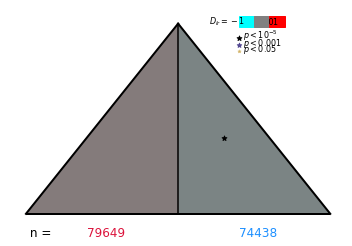

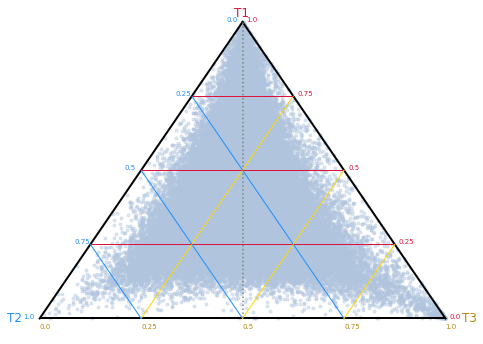

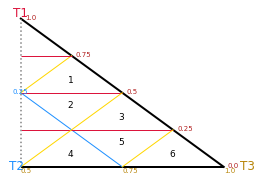

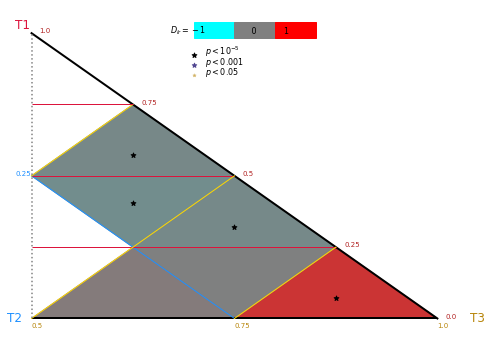

In [20]:
granuality = "coarse"
res=run_analysis("weights.csv",granuality)

In [21]:
res.head()

,"coord. (T1, T2, T3)",n_right,n_left,D-LR,g-test,p-value(g-test),index
0,"[(0.0, 0.25), (0.0, 0.25), (0.75, 1.0)]",833,213,5.9273e-01,3.9277e+02,0.0000e+00,6
1,"[(0.0, 0.25), (0.0, 0.25), (0.5, 0.75)]",3102,3133,-4.9719e-03,1.5413e-01,6.9462e-01,5
2,"[(0.0, 0.25), (0.25, 0.5), (0.5, 0.75)]",1757,1644,3.3226e-02,3.7552e+00,5.2644e-02,4
3,"[(0.25, 0.5), (0.0, 0.25), (0.5, 0.75)]",1958,2264,-7.2477e-02,2.2198e+01,2.4598e-06,3
4,"[(0.25, 0.5), (0.0, 0.25), (0.25, 0.5)]",12888,15974,-1.0692e-01,3.3059e+02,0.0000e+00,2


d_lr = -0.033818557048939886

g-test = 176.2621080957174

g-test- p value= 0.0


(74438, 79649, -0.033818557048939886, 176.2621080957174, 0.0)

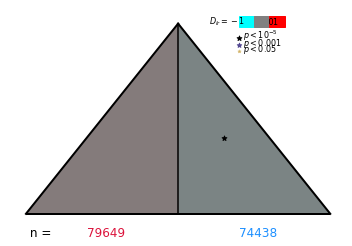

In [22]:
run_basic_analysis("weights.csv")